In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import prepare as p
import acquire as a

import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics

import env

In [5]:
df = pd.read_csv('https://gist.githubusercontent.com/ryanorsinger/19bc7eccd6279661bd13307026628ace/raw/e4b5d6787015a4782f96cad6d1d62a8bdbac54c7/lemonade.csv')
df.head()

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales
0,1/1/17,Sunday,27.0,2.00,15,0.5,10
1,1/2/17,Monday,28.9,1.33,15,0.5,13
2,1/3/17,Tuesday,34.5,1.33,27,0.5,15
3,1/4/17,Wednesday,44.1,1.05,28,0.5,17
4,1/5/17,Thursday,42.4,1.00,33,0.5,18


In [7]:
def get_lower_and_upper_bounds(df, k):
    
    a = []
    b = []
    fences = [a, b]
    features = []
    
    for col in df.columns.to_list():
        if df[col].dtype == 'float64' or df[col].dtype == 'int64':

            # for each feature find the first and third quartile
            q1, q3 = df[col].quantile([.25, .75])

            # calculate inter quartile range
            iqr = q3 - q1

            # calculate the upper and lower fence
            upper_fence = q3 + (k * iqr)
            lower_fence = q1 - (k * iqr)
            
            # appending upper and lower fence to lists
            a.append(upper_fence)
            b.append(lower_fence)

            # appending the feature names to a list
            features.append(col)

            # assigning the fences and feature names to a dataframe
            var_fences= pd.DataFrame(fences, columns=features, index=['upper_fence', 'lower_fence'])
            
    return var_fences
    

In [10]:
var_fences = get_lower_and_upper_bounds(df, 1.5)
var_fences

,Temperature,Rainfall,Flyers,Price,Sales
upper_fence,104.7,1.30,76.0,0.5,45.0
lower_fence,16.7,0.26,4.0,0.5,5.0


The outliers for these appear to be a little too close to the actual data and I would recommend increasing the k value.  
We should definitely keep the price outliers, given that the price column is only .5 so there are no outliers.

In [11]:
var_fences = get_lower_and_upper_bounds(df, 3)
var_fences

,Temperature,Rainfall,Flyers,Price,Sales
upper_fence,137.7,1.69,103.0,0.5,60.0
lower_fence,-16.3,-0.13,-23.0,0.5,-10.0


The outliers are very far from the data and the lower bound on 3 of the columns are too low for any data to appear below them.  
Once again we should not remove any values from the price column due to there only being one value in that column.

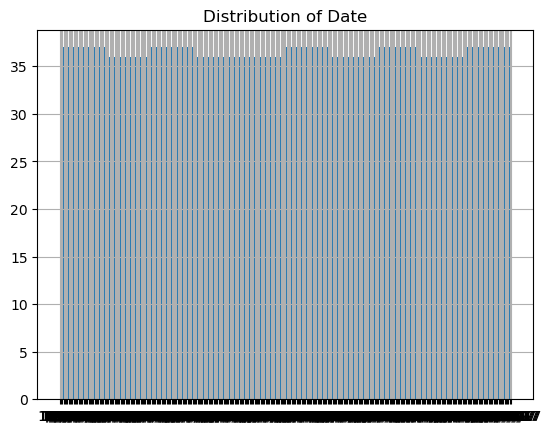

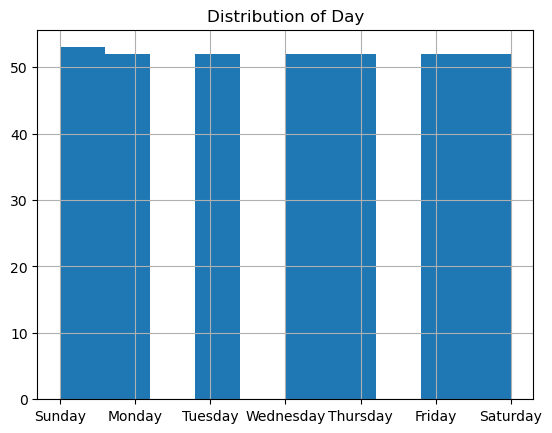

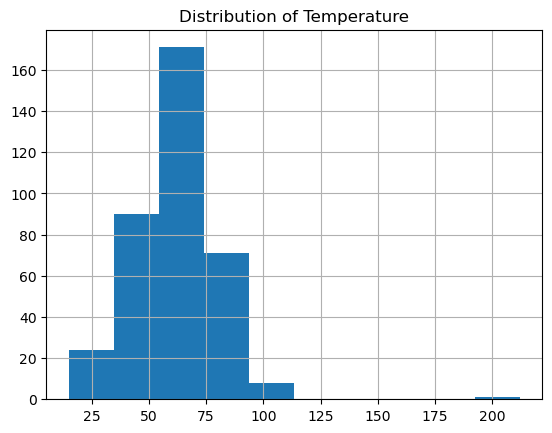

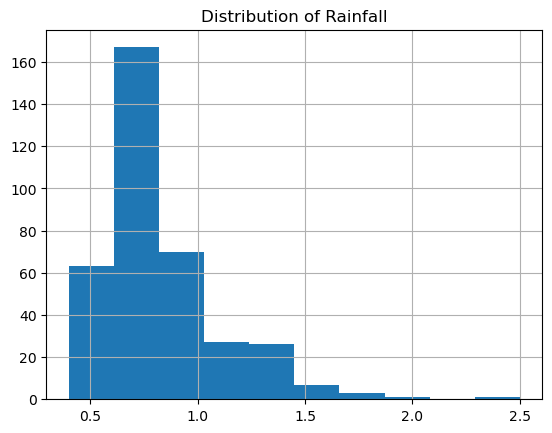

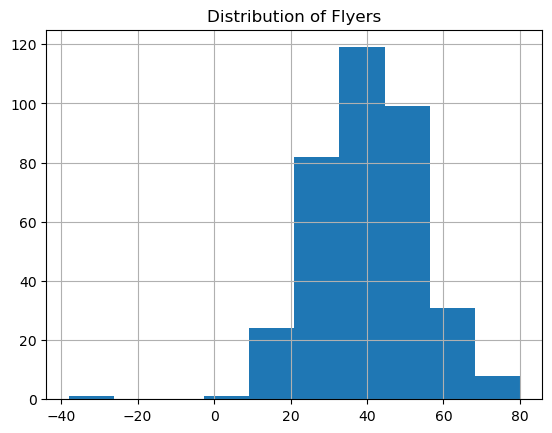

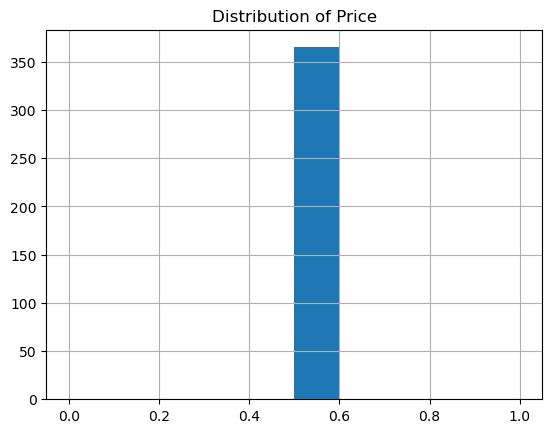

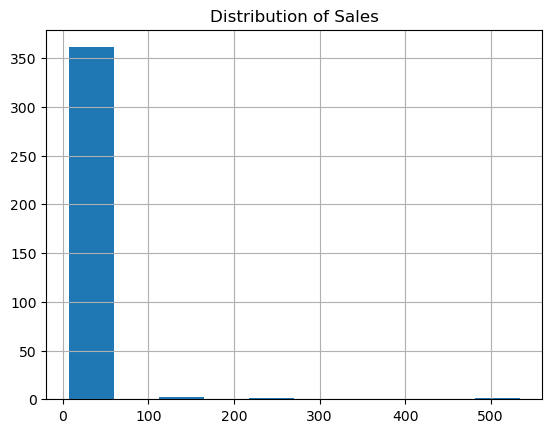

In [15]:
for col in df.columns.to_list():
    
    df[col].hist()
    plt.title(f'Distribution of {col}')
    plt.show()

In [16]:
cols = ['Temperature', 'Rainfall','Flyers']

In [17]:
zscores_temp = pd.Series((df['Temperature'] - df['Temperature'].mean()) / df['Temperature'].std())

In [18]:
zscores_rain = pd.Series((df['Rainfall'] - df['Rainfall'].mean()) / df['Rainfall'].std())

In [20]:
zscores_fly = pd.Series((df['Flyers'] - df['Flyers'].mean()) / df['Flyers'].std())

In [21]:
df['Temperature'][zscores_temp.abs() >= 2]

41     212.0
166     99.3
176    102.6
181    102.9
190     98.0
198     99.3
202     99.6
207     97.9
338     22.0
364     15.1
Name: Temperature, dtype: float64

In [22]:
df['Rainfall'][zscores_rain.abs() >= 2]

0      2.00
5      1.54
6      1.54
10     1.54
15     1.67
16     1.43
19     1.43
23     1.54
337    1.54
338    1.82
342    1.43
343    1.82
346    1.43
347    1.54
351    1.43
355    1.54
359    1.43
363    1.43
364    2.50
Name: Rainfall, dtype: float64

In [23]:
df['Flyers'][zscores_fly.abs() >= 2]

166    77
170    70
171    76
182    68
183    68
194    80
198    76
203    72
204    69
207    74
324   -38
338    11
364     9
Name: Flyers, dtype: int64

In [25]:
df['Rainfall'][zscores_rain.abs() >= 3]

0      2.00
15     1.67
338    1.82
343    1.82
364    2.50
Name: Rainfall, dtype: float64

In [26]:
df['Flyers'][zscores_fly.abs() >= 3]

324   -38
Name: Flyers, dtype: int64

In [30]:
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.username}:{env.password}@{env.hostname}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [31]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

In [32]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )


In [33]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502


<AxesSubplot:>

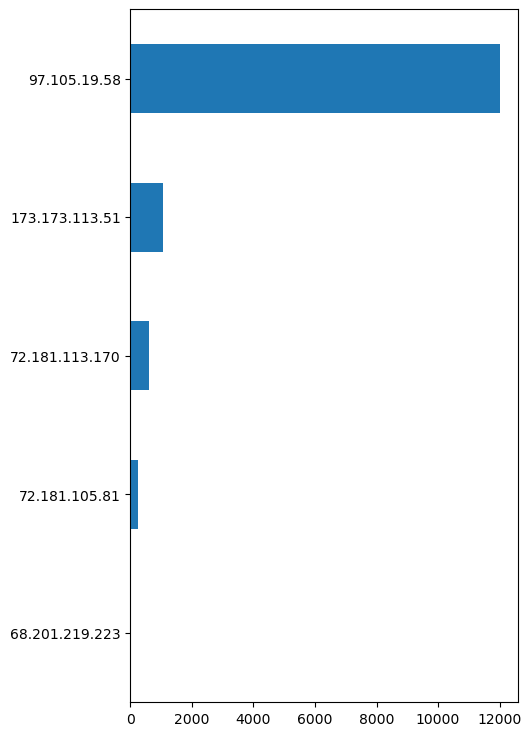

In [34]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))


In [35]:
df.shape

(13978, 8)

In [36]:
value_counts_and_frequencies(df['request_method'])

,count,proba
GET,13978,1.0


In [38]:
value_counts_and_frequencies(df['http_version'])

,count,proba
HTTP/1.1,13978,1.0


In [39]:
value_counts_and_frequencies(df['user_agent'])

,count,proba
python-requests/2.21.0,12005,0.858850
python-requests/2.20.1,1911,0.136715
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",34,0.002432
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0,8,0.000572
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots),7,0.000501
Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",4,0.000286
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36",2,0.000143
Python-urllib/3.7,1,0.000072


In [40]:
value_counts_and_frequencies(df['request_path'])

,count,proba
/api/v1/sales?page=2,709,0.050723
/api/v1/items,464,0.033195
/api/v1/items?page=2,291,0.020818
/api/v1/items?page=3,219,0.015667
/api/v1/stores,162,0.011590
...,...,...
/api/v1,1,0.000072
/api/v1//api/v1/items/next_page,1,0.000072
/api/v1//api/v1/items,1,0.000072
/api/v1/items?page=0,1,0.000072


In [43]:
get_lower_and_upper_bounds(df, 3)

,size
upper_fence,543253.0
lower_fence,468675.0


In [44]:
def acquire(file_name, column_names):
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['endpoint'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight):
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]
